<a href="https://colab.research.google.com/github/Pulsar-kkaturi/DL-Education/blob/master/VisionDL_Lecture/Lecture4_CNNBuild_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 4. CNN build
* Ref. 최건호, 파이토치 첫걸음, 한빛미디어 ([link](https://drive.google.com/drive/folders/12zphz36T6gEJac6WScnvRN27-f1tfHO1))

## 1. 인공신경망 (Deep Neural Network; DNN)
* 2장의 선형회귀모델과 달리, 비선형인 2차함수에 대한 회귀모델을 딥러닝으로 구현해보자!
* y = x<sup>2</sup>+3

### 1.1. 라이브러리 및 데이터 만들기

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
# GPU에서 학습을 위해 GPU check
print("사용 가능한 GPU가 존재하는가? (True or False): ", torch.cuda.is_available())
if torch.cuda.is_available():
    print("사용 가능한 GPU의 수는 {} 개 입니다.".format(torch.cuda.device_count()))
    print("GPU 각각의 이름은 아래와 같습니다.")
    for i in range(torch.cuda.device_count()):
        print("GPU {}: {}".format(i, torch.cuda.get_device_name(i)))
else:
    print("사용 가능한 GPU가 존재하지 않습니다. 혹은 GPU를 Pytorch가 찾지 못하고 있습니다.")

사용 가능한 GPU가 존재하는가? (True or False):  False
사용 가능한 GPU가 존재하지 않습니다. 혹은 GPU를 Pytorch가 찾지 못하고 있습니다.


In [ ]:
# 데이터 생성
num_data = 1000

noise = init.normal_(torch.FloatTensor(num_data,1),std=3)
x = init.uniform_(torch.Tensor(num_data,1),-15,15)
y = (x**2) + 3
y_noise = y + noise

In [ ]:
# 데이터 시각화
plt.figure(figsize=(8,8))
plt.scatter(x.numpy(), y_noise.numpy(), s=3, c='gray', label='Original Data') # 학습시킬 실제 데이터 분포
plt.scatter(x.numpy(), y.numpy(), s=3, c='red', label='Label Data') # 정답 분포
plt.legend()

### 1.2. 모델 생성 및 학습

In [ ]:
# 3장의 예시처럼 하나의 값이 들어가서 하나의 값이 나오기 때문에 모델의 처음과 끝 특성의 개수는 1개입니다.

# https://pytorch.org/docs/stable/nn.html?highlight=sequential
# torch.nn.Sequential
# Sequential 모듈은 다양한 모듈을 담을 수 있는 일종의 리스트라고 보면 됩니다.
# Sequential 에 정의된 순서대로 연산이 진행되며, 많은 연산을 묶어서 한번에 관리할 수 있어서 편리합니다.

# 아래 코드는 특성의 개수가 1 -> 6 -> 10 -> 6 -> 1개로 변하는 인공신경망입니다.
# 또한 선형변환 이후 활성화 함수를 넣어 비선형성이 생기도록 했습니다.

model = nn.Sequential(
          nn.Linear(1,6),
          nn.ReLU(),
          nn.Linear(6,10),
          nn.ReLU(),
          nn.Linear(10,6),
          nn.ReLU(),
          nn.Linear(6,1),
      )

loss_func = nn.L1Loss() # 손실함수로는 L1(절대값의 평균) loss 사용
optimizer = optim.SGD(model.parameters(),lr=0.0002) # 옵티마이저로는 SGD 사용

In [ ]:
num_epoch = 10000 # 학습시킬 epoch 수
device = 'cuda:0' # 학습시킬 gpu
loss_array = []
pbar = tqdm(total=num_epoch) # tqdm으로 학습 진행도 확인 가능
for i in range(num_epoch):
    x.to(device)
    y_noise.to(device)
    optimizer.zero_grad()
    output = model(x)

    loss = loss_func(output,y_noise)
    loss.backward() # 역전파 손실 연산
    optimizer.step() # 옵티마이저로 가중치 업데이트

    pbar.set_description(f"Processing({i+1}/{num_epoch}): loss={loss.data}")
    pbar.update(1)
    loss_array.append(loss.detach().numpy()) # 손실값의 데이터만 numpy로 보냄
pbar.close()

### 1.3. 결과 확인

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(loss_array)
# plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(x.detach().numpy(),y_noise, s=3, c='grey', label="Original Data")
plt.scatter(x.detach().numpy(),y, s=3, c='red', label="Label Data")
plt.scatter(x.detach().numpy(),output.detach().numpy(), s=3, c='blue',label="Model Output")
plt.legend()

## 2. 합성곱 신경망 (Convolutional Neural Network; CNN)

* MNIST 데이터 사용
* 기초적인 합성곱 신경망 실습

In [ ]:
# Colab에서 실행시 파이토치 설치
#!pip install torch torchvision

### 2.1. 환경 세팅

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

# https://pytorch.org/vision/stable/datasets.html
# 파이토치에서는 torchvision.datasets에 MNIST 등의 다양한 데이터를 사용하기 용이하게 정리해놨습니다.
# 이를 사용하면 데이터를 따로 학습에 맞게 정리하거나 하지 않아도 바로 사용이 가능합니다.
import torchvision.datasets as dset

# https://pytorch.org/vision/stable/transforms.html
# torchvision.transforms에는 이미지 데이터를 자르거나 확대 및 다양하게 변형시키는 함수들이 구현되어 있습니다.
import torchvision.transforms as transforms

# https://pytorch.org/docs/stable/data.html
# DataLoader는 전처리가 끝난 데이터들을 지정한 배치 크기에 맞게 모아서 전달해주는 역할을 합니다.
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print(torch.__version__)

2.0.0+cu117


In [2]:
# Pytorch GPU check
import os, torch
print("현재 pytorch 버전은 무엇인가? : %s" %(torch.__version__))
print("사용 가능한 GPU가 존재하는가? (True or False): ", torch.cuda.is_available())
if torch.cuda.is_available():
    print("사용 가능한 GPU의 수는 {} 개 입니다.".format(torch.cuda.device_count()))
    print("GPU 각각의 이름은 아래와 같습니다.")
    for i in range(torch.cuda.device_count()):
        print("GPU {}: {}".format(i, torch.cuda.get_device_name(i)))
else:
    print("사용 가능한 GPU가 존재하지 않습니다. 혹은 GPU를 Pytorch가 찾지 못하고 있습니다.")

현재 pytorch 버전은 무엇인가? : 2.0.0+cu117
사용 가능한 GPU가 존재하는가? (True or False):  True
사용 가능한 GPU의 수는 4 개 입니다.
GPU 각각의 이름은 아래와 같습니다.
GPU 0: NVIDIA GeForce GTX TITAN X
GPU 1: NVIDIA GeForce GTX TITAN X
GPU 2: NVIDIA GeForce GTX TITAN X
GPU 3: NVIDIA GeForce GTX TITAN X


In [3]:
device = 'cuda:0'
a = torch.FloatTensor([1, 2])
a = a.to(device)
print(a) # device에 지정한 cuda가 뜬다면 GPU 잡고 있는 것!

tensor([1., 2.], device='cuda:0')


### 2.2. 데이터셋

In [4]:
# https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=mnist#torchvision.datasets.MNIST
# 첫번째 인자 root는 데이터를 저장할 위치, train은 학습용 데이터인지 테스트용 데이터인지의 여부를 의미합니다.
data_path = '/home/student/Datasets/jhjeong/Test/' # 자신의 환경에 맞게 설정!

# MNIST 데이터는 숫자 손글씨 이미지와 이에 대한 정답 쌍으로 이루어져 있습니다.
# transform은 이미지에 대한 변형, target_transform은 정답 라벨에 대한 변형을 의미합니다.
# transform.ToTensor()는 PIL 이미지나 Numpy 배열을 토치 텐서로 바꿔줍니다.

# download는 데이터가 저장할 위치에 없을 경우 새로 다운받을지 여부입니다.
mnist_train = dset.MNIST(root=data_path, train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST(root=data_path, train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 865999.29it/s] 


Extracting /home/student/Datasets/jhjeong/Test/MNIST/raw/train-images-idx3-ubyte.gz to /home/student/Datasets/jhjeong/Test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 105002.30it/s]


Extracting /home/student/Datasets/jhjeong/Test/MNIST/raw/train-labels-idx1-ubyte.gz to /home/student/Datasets/jhjeong/Test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:07<00:00, 226405.93it/s]


Extracting /home/student/Datasets/jhjeong/Test/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/student/Datasets/jhjeong/Test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5053190.65it/s]

Extracting /home/student/Datasets/jhjeong/Test/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/student/Datasets/jhjeong/Test/MNIST/raw



* MNIST Dataset 구조: (frame1(image, label), frame2(image, label), ..., frame60000(image, label))
* index 순서 : mnist_train[frame_index(0~60000)][0(image) or 1(label)]

In [5]:
# 데이터셋 확인 (torch tensor)
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

print(len(mnist_train),len(mnist_test))

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000
60000 10000


torch.Size([1, 28, 28])
5


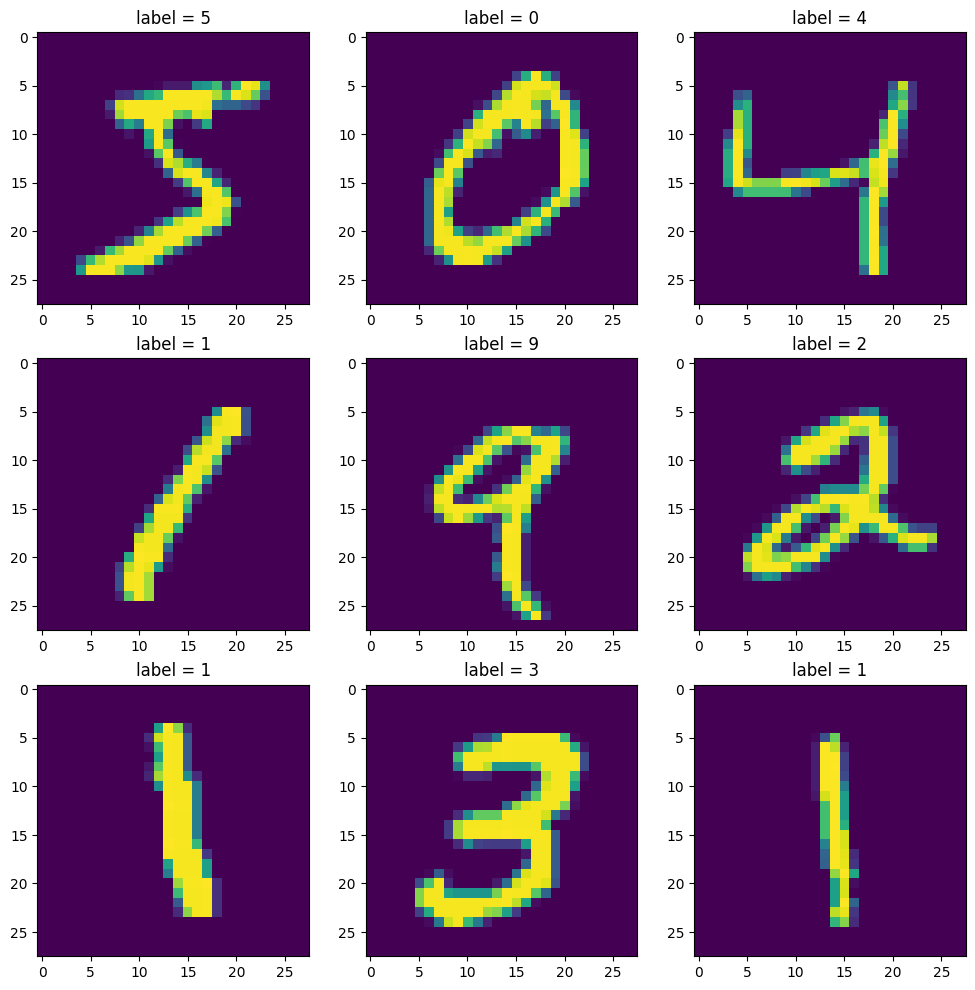

In [6]:
print(mnist_train[0][0].size()) # 0번째 프레임의 이미지 크기 출력
print(mnist_train[0][1]) # 0번째 프레임의 레이블(정답) 출력
plt.figure(figsize=(12,12))
for i in range(3*3): # 9개의 데이터 추가 확인
    plt.subplot(3,3,i+1)
    plt.imshow(np.moveaxis(mnist_train[i][0].numpy(), 0, -1)) # np.moveaxis()는 channel 위치를 0 -> -1로 옮겨준다.
    plt.title(f'label = {mnist_train[i][1]}')

* DataLoader 설정
    - batch_size = 배치 사이즈
    - shuffle = 섞을지 여부
    - num_workers = 데이터를 묶을때 사용할 프로세스 수
    - drop_last = 묶고 남은 데이터를 버릴지 여부

In [7]:
batch_size = 256

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

### 2.3. 모델 만들기

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5),             # [batch_size,1,28,28] -> [batch_size,16,24,24]
            nn.ReLU(),                                                          # 필터의 개수는 1개(흑백이미지)에서 16개로 늘어나도록 임의로 설정했습니다.
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5),            # [batch_size,16,24,24] -> [batch_size,32,20,20]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),                               # [batch_size,32,20,20] -> [batch_size,32,10,10]
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),          # [batch_size,32,10,10] -> [batch_size,64,6,6]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)                                # [batch_size,64,6,6] -> [batch_size,64,3,3]
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3,100),                                              # [batch_size,64*3*3] -> [batch_size,100]
            nn.ReLU(),
            nn.Linear(100,10)                                                   # [batch_size,100] -> [batch_size,10]
        )

    def forward(self,x):
        out = self.layer(x)                                                     # self.layer에 정의한 Sequential의 연산을 차례대로 다 실행합니다.
        out = out.view(batch_size,-1)                                           # view 함수를 이용해 텐서의 형태를 [batch_size,나머지]로 바꿔줍니다. 2차원 이미지를 1차원으로 펴주는 과정
                                                                                # ex) 2x3 형태였던 텐서를 .view(1,-1) 해주면 1x6의 형태로 바뀝니다. .view(3,-1)이면 3x2로 바뀜.
                                                                                # 만약 전체 텐서의 크기가 batch_size로 나누어 떨어지지 않으면 오류가 납니다.
        out = self.fc_layer(out)
        return out

In [9]:
# gpu가 사용 가능한 경우에는 device를 gpu로 설정하고 불가능하면 cpu로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 모델을 지정한 장치로 올립니다.
model = CNN().to(device)

# 손실함수로는 크로스엔트로피를 사용합니다.
loss_func = nn.CrossEntropyLoss()

# 최적화함수로는 Adam을 사용합니다.
learning_rate = 0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


### 2.4. 모델 학습

In [10]:
# 학습 모듈
def train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    pbar = tqdm(total=num_batches)
    train_loss, train_acc = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metric
        correct = (pred.argmax(1) == y).type(torch.float).sum().item()

        # Epoch result
        train_loss += loss.item()
        train_acc += correct

        # Traing Process check
        loss, current = loss.item(), (batch + 1) * len(x)
        acc = correct/len(x)
        pbar.set_description(f" - Batch Training[{epoch}]({current}/{size}): loss = {loss:>5f}, acc = {100*acc:>0.1f}%")
        pbar.update(1)
    pbar.close()
    # epoch
    train_loss /= num_batches
    train_acc /= size
    return train_loss, train_acc

In [11]:
# 검증 모듈
def test(dataloader, model, loss_fn, epoch, show=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            test_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    test_acc /= size
    if show:
        print(f"    = Validation[{epoch}]: val_loss = {test_loss:>5f}, val_acc: {(100*test_acc):>0.1f}%")
    return test_loss, test_acc

In [12]:
num_epoch = 10

history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
for t in range(num_epoch):
    train_loss, train_acc = train(train_loader, model, loss_func, optimizer, t+1)
    val_loss, val_acc = test(test_loader, model, loss_func, t+1)
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    print(f'# Training[{t+1}/{num_epoch}]: loss = {train_loss:>5f}, acc = {100*train_acc:>0.1f}, val_loss = {val_loss:5>f}, val_acc = {100*val_acc:>0.1f}')

 - Batch Training[1](59904/60000): loss = 0.238637, acc = 93.0%: 100%|██████████| 234/234 [00:04<00:00, 49.10it/s]


# Training[1/10]: loss = 0.738685, acc = 78.3, val_loss = 0.246905, val_acc = 92.5


 - Batch Training[2](59904/60000): loss = 0.126765, acc = 95.3%: 100%|██████████| 234/234 [00:04<00:00, 58.01it/s]


# Training[2/10]: loss = 0.203503, acc = 93.8, val_loss = 0.135354, val_acc = 95.8


 - Batch Training[3](59904/60000): loss = 0.124705, acc = 97.3%: 100%|██████████| 234/234 [00:04<00:00, 57.17it/s]


# Training[3/10]: loss = 0.127924, acc = 96.0, val_loss = 0.087800, val_acc = 97.2


 - Batch Training[4](59904/60000): loss = 0.110038, acc = 96.5%: 100%|██████████| 234/234 [00:04<00:00, 57.92it/s]


# Training[4/10]: loss = 0.091146, acc = 97.1, val_loss = 0.071703, val_acc = 97.7


 - Batch Training[5](59904/60000): loss = 0.049839, acc = 98.0%: 100%|██████████| 234/234 [00:03<00:00, 59.05it/s] 


# Training[5/10]: loss = 0.073684, acc = 97.6, val_loss = 0.063584, val_acc = 98.0


 - Batch Training[6](59904/60000): loss = 0.069295, acc = 96.9%: 100%|██████████| 234/234 [00:03<00:00, 58.68it/s] 


# Training[6/10]: loss = 0.061681, acc = 98.0, val_loss = 0.051280, val_acc = 98.2


 - Batch Training[7](59904/60000): loss = 0.050517, acc = 98.8%: 100%|██████████| 234/234 [00:04<00:00, 57.98it/s] 


# Training[7/10]: loss = 0.053334, acc = 98.2, val_loss = 0.046938, val_acc = 98.3


 - Batch Training[8](59904/60000): loss = 0.058599, acc = 97.7%: 100%|██████████| 234/234 [00:04<00:00, 57.90it/s] 


# Training[8/10]: loss = 0.046697, acc = 98.4, val_loss = 0.039868, val_acc = 98.6


 - Batch Training[9](59904/60000): loss = 0.015495, acc = 100.0%: 100%|██████████| 234/234 [00:04<00:00, 58.45it/s]


# Training[9/10]: loss = 0.042889, acc = 98.5, val_loss = 0.036144, val_acc = 98.7


 - Batch Training[10](59904/60000): loss = 0.042371, acc = 99.2%: 100%|██████████| 234/234 [00:04<00:00, 58.09it/s] 


# Training[10/10]: loss = 0.039419, acc = 98.6, val_loss = 0.035480, val_acc = 98.7


### 2.5. 결과 분석

In [13]:
for key in history.keys():
    print(key, history[key])

loss [0.738684959964365, 0.203502978460911, 0.12792354425749716, 0.09114555046599135, 0.07368376131495859, 0.061681051284838945, 0.05333377252547787, 0.046697052820529945, 0.04288911773687881, 0.03941910104372372]
val_loss [0.24690535206061143, 0.13535356883389446, 0.0877997231645844, 0.07170262736960864, 0.06358394247945398, 0.05128045770703839, 0.046937754103101983, 0.03986750818783035, 0.036144354653049215, 0.03548001808499416]
acc [0.7829666666666667, 0.9382, 0.9601666666666666, 0.97105, 0.9763, 0.97955, 0.9822666666666666, 0.9840666666666666, 0.9849666666666667, 0.9863666666666666]
val_acc [0.9253, 0.9581, 0.9717, 0.977, 0.9798, 0.9816, 0.9834, 0.986, 0.9871, 0.9869]


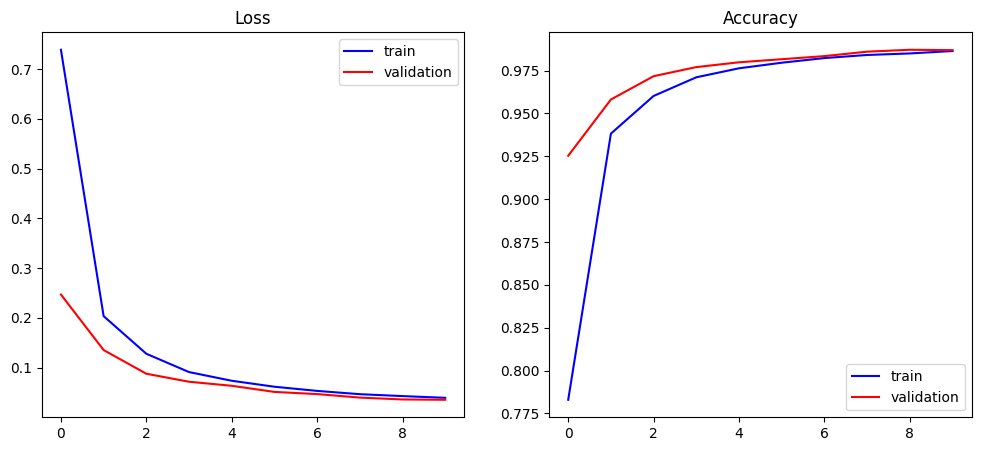

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Loss')
plt.plot(history['loss'], c='b', label='train')
plt.plot(history['val_loss'], c='r', label='validation')
plt.legend()
plt.subplot(122)
plt.title('Accuracy')
plt.plot(history['acc'], c='b', label='train')
plt.plot(history['val_acc'], c='r', label='validation')
plt.legend()

In [15]:
pred_dic = {'prob': [], 'pred': []}
with torch.no_grad():
    for img, lab in test_loader:
        x = img.to(device)
        pred = model.forward(x)
        for i in range(len(x)):
            probs = pred[i].cpu().detach().numpy()
            # probs -= np.min(probs)
            # probs /= np.sum(probs)
            pred_dic['prob'].append(probs)
            pred_dic['pred'].append(pred[i].argmax().item())
print(pred_dic['pred'][0])
print(pred_dic['prob'][0])
print(len(pred_dic['pred']))

7
[ -1.1753672  -1.6953626   3.448867    3.3513272  -2.3976216  -0.8580692
 -14.368204   12.830996    1.088851    3.5530412]
9984


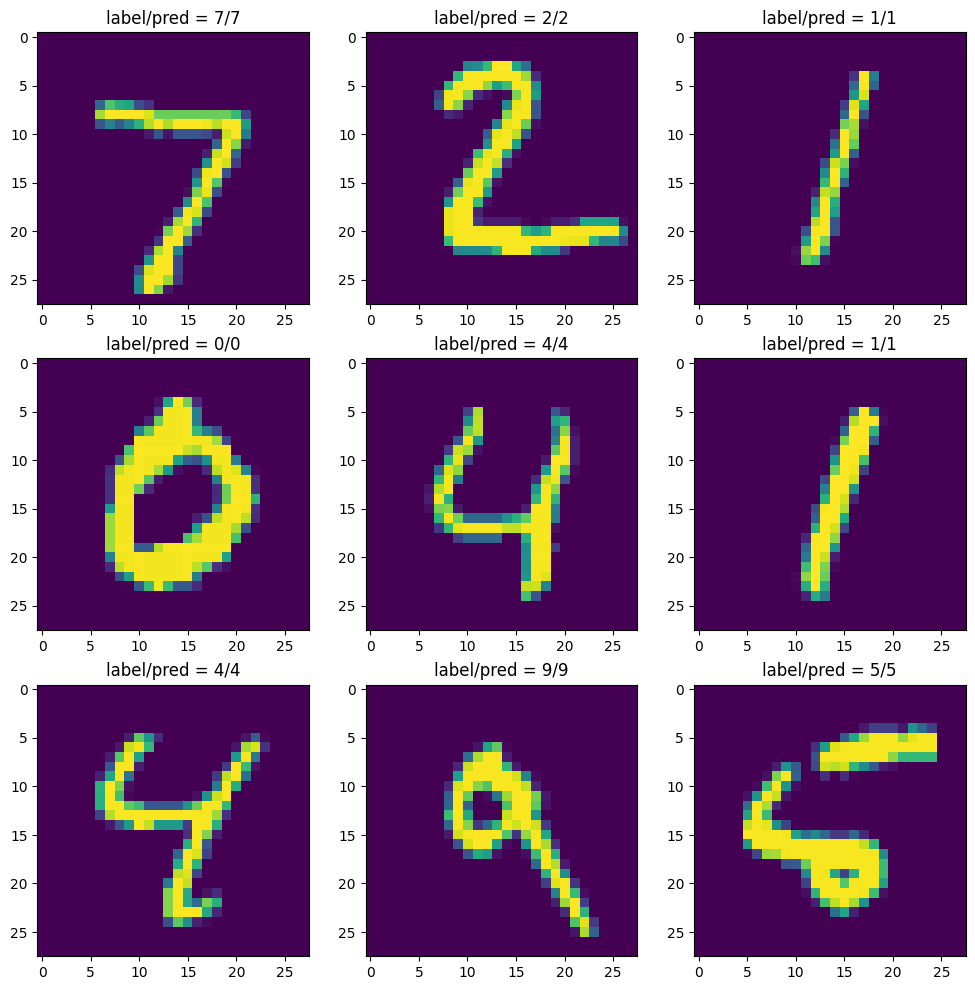

In [16]:
plt.figure(figsize=(12,12))
for i in range(9):
    img = np.moveaxis(mnist_test[i][0].detach().numpy(), 0 , -1)
    pred = pred_dic['pred'][i]
    # score = pred_dic['prob'][i][pred]
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(f'label/pred = {mnist_test[i][1]}/{pred}')

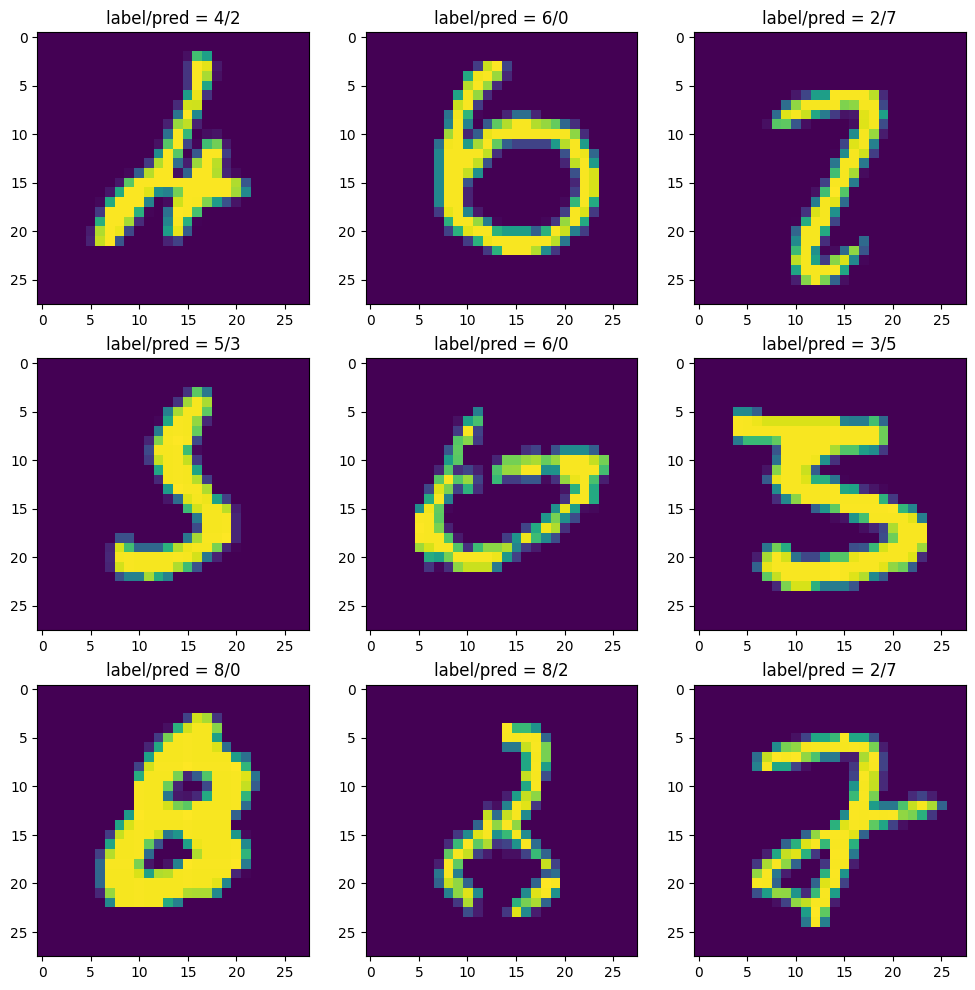

In [17]:
# false case
plt.figure(figsize=(12,12))
n = 0
for i in range(len(pred_dic['pred'])):
    pred = pred_dic['pred'][i]
    lab = mnist_test[i][1]
    if pred != lab and n < 9:
        n += 1
        img = np.moveaxis(mnist_test[i][0].detach().numpy(), 0 , -1)
        plt.subplot(3,3,n)
        plt.imshow(img)
        plt.title(f'label/pred = {mnist_test[i][1]}/{pred}')

## 3. Simple FCN

### 3.1. 환경 세팅

In [18]:
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

# https://pytorch.org/vision/stable/datasets.html
# 파이토치에서는 torchvision.datasets에 MNIST 등의 다양한 데이터를 사용하기 용이하게 정리해놨습니다.
# 이를 사용하면 데이터를 따로 학습에 맞게 정리하거나 하지 않아도 바로 사용이 가능합니다.
import torchvision.datasets as dset

# https://pytorch.org/vision/stable/transforms.html
# torchvision.transforms에는 이미지 데이터를 자르거나 확대 및 다양하게 변형시키는 함수들이 구현되어 있습니다.
import torchvision.transforms as transforms

# https://pytorch.org/docs/stable/data.html
# DataLoader는 전처리가 끝난 데이터들을 지정한 배치 크기에 맞게 모아서 전달해주는 역할을 합니다.
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

# 기본 라이브러리
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 영상처리 관련 라이브러리 불러오기
import skimage
from skimage import io as skio
from skimage import transform as skit
from skimage import morphology as skim

print(torch.__version__)

2.0.0+cu117


### 3.2. 데이터셋

#### 3.2.1. 데이터셋 다운로드

* Dataset Download
  - reference link: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation

In [ ]:
# 데이터셋을 이 세션으로 불러오기
!git clone https://github.com/Pulsar-kkaturi/DL-Education.git

In [ ]:
# 압축 풀기
!tar -zxf ./DL-Education/dataset/brain_seg_2d.tar.gz

#### 3.2.2. 데이터셋 불러오기

In [ ]:
img_fol_path = './brain_seg_2d/images'
msk_fol_path = './brain_seg_2d/masks'
img_file_list = [f for f in sorted(os.listdir(img_fol_path))]
msk_file_list = [f for f in sorted(os.listdir(msk_fol_path))]
# print(img_file_list)
# print(msk_file_list)

img_list, msk_list = [], []
for i, i_ in enumerate(img_file_list):
  img_path = os.path.join(img_fol_path, i_)
  msk_path = os.path.join(msk_fol_path, msk_file_list[i])
  img_arr = skio.imread(img_path)
  msk_arr = skio.imread(msk_path)
  img_list.append(img_arr)
  msk_list.append(msk_arr)

print('Image numbers = ', len(img_list))
print('Mask numbers = ', len(msk_list))

* 이미지 정보 & 마스크 정보 확인

In [ ]:
# 이미지 정보
print('이미지 크기 = ', img_list[0].shape)
print(f'이미지 최대값/최소값 = {np.max(img_list[0])}/{np.min(img_list[0])}')
# 마스크 정보
print('마스크 크기 = ', msk_list[0].shape)
print(f'마스크 최대값/최소값 = {np.max(msk_list[0])}/{np.min(msk_list[0])}')

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.title('Image')
plt.imshow(img_list[0])
plt.subplot(132)
plt.title('Mask')
plt.imshow(msk_list[0])
plt.subplot(133)
plt.title('Overlay')
plt.imshow(img_list[0], cmap='gray')
plt.imshow(msk_list[0], cmap='Reds', alpha=0.3)

#### 3.2.3. 데이터셋 전처리

* Original Mask

In [ ]:
img_size = (200, 200) # 이미지 사이즈 정규화
num_classes = 1 # 레이블 종류 (tumor 1개)

# 이미지 전처리
resized_imgs = [skit.resize(img, img_size, anti_aliasing=True) for img in img_list] # 이미지 크기 리사이징
img_arrays = np.expand_dims(np.array(resized_imgs, dtype=np.float32), axis=-1) # 이미지를 array로 변환
input_imgs = (img_arrays - np.min(img_arrays))/(np.max(img_arrays)-np.min(img_arrays)) # 이미지 정규화 (0~1)

# 마스크 전처리
resized_msks = [skit.resize(msk, img_size) for msk in msk_list] # 이미지 크기 리사이징
msk_arrays = np.expand_dims(np.array(resized_msks), axis=-1) # 마스크를 array로 변환
targets = np.where(msk_arrays > 0, 1, 0) # 레이블 형태(0,1)로 변환
targets = targets.astype(np.uint8)

# 이미지 정보
print('입력 어레이 크기 = ', input_imgs.shape)
print(f'입력 어레이 최대값/최소값 = {np.max(input_imgs)}/{np.min(input_imgs)}')
# 마스크 정보
print('타겟 어레이 크기 = ', targets.shape)
print(f'타켓 어레이 최대값/최소값 = {np.max(targets)}/{np.min(targets)}')

In [ ]:
# 검증 데이터셋 분할
num_val_samples = 100 # 검증 데이터셋에는 100건 사용
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

# 검증 데이터셋 확인
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.title('Image')
plt.imshow(val_input_imgs[0])
plt.subplot(132)
plt.title('Mask')
plt.imshow(val_targets[0])
plt.subplot(133)
plt.title('Overlay')
plt.imshow(val_input_imgs[0], cmap='gray')
plt.imshow(val_targets[0], cmap='Reds', alpha=0.3)

#### 3.2.4. New Mask 전처리

* New Mask
    * FCN에서 Brain Tumor는 생각보다 어려울 것이므로, 그냥 두경부 전체를 분할하는 것으로 목표를 바꾸자!
    * ORG Mask(3.2.3)와 New Mask(3.2.4) 둘 중 하나만 실행시킨 뒤 모델학습으로 넘어가서 성능을 비교해보자!

In [ ]:
img_size = (200, 200) # 이미지 사이즈 정규화
num_classes = 1 # 레이블 종류 (tumor 1개)

# 이미지 전처리
resized_imgs = [skit.resize(img, img_size, anti_aliasing=True) for img in img_list] # 이미지 크기 리사이징
img_arrays = np.expand_dims(np.array(resized_imgs, dtype=np.float32), axis=-1) # 이미지를 array로 변환
input_imgs = (img_arrays - np.min(img_arrays))/(np.max(img_arrays)-np.min(img_arrays)) # 이미지 정규화 (0~1)

# 마스크 전처리
new_msk_list = [skim.closing(np.where(img > 20,  1, 0)) for img in img_list] # 레이블 형태(0,1)로 변환
resized_msks = [skit.resize(msk, img_size) for msk in new_msk_list] # 이미지 크기 리사이징
msk_arrays = np.expand_dims(np.array(resized_msks), axis=-1) # 마스크를 array로 변환
targets = np.where(msk_arrays > 0, 1, 0) # 레이블 형태(0,1)로 변환

targets = targets.astype(np.uint8)

# 이미지 정보
print('입력 어레이 크기 = ', input_imgs.shape)
print(f'입력 어레이 최대값/최소값 = {np.max(input_imgs)}/{np.min(input_imgs)}')
# 마스크 정보
print('타겟 어레이 크기 = ', targets.shape)
print(f'타켓 어레이 최대값/최소값 = {np.max(targets)}/{np.min(targets)}')

In [ ]:
# 검증 데이터셋 분할
num_val_samples = 100 # 검증 데이터셋에는 100건 사용
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

# 검증 데이터셋 확인
plt.figure(figsize=(12,12))
for i in range(3):
  plt.subplot(3,3,1+3*i)
  plt.title('Image')
  plt.imshow(val_input_imgs[i])
  plt.subplot(3,3,2+3*i)
  plt.title('Mask')
  plt.imshow(val_targets[i])
  plt.subplot(3,3,3+3*i)
  plt.title('Overlay')
  plt.imshow(val_input_imgs[i], cmap='gray')
  plt.imshow(val_targets[i], cmap='Reds', alpha=0.3)

### 3.3. 모델 만들기

#### 3.3.1. 모델 학습 준비

In [ ]:
class BrainDataset(Dataset):
    def __init__(self, img_list, resize=200):
        self.img_list = img_list
        self.resize = (resize, resize)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        img_arr = skio.imread(img_path)

        # 이미지 전처리
        input_arr = skit.resize(img_arr, self.resize, anti_aliasing=True) # 이미지 크기 리사이징
        input_arr = np.expand_dims(np.array(input_arr), axis=0) # 이미지를 tensor로 변환
        input_arr = (input_arr - np.min(input_arr))/(np.max(input_arr)-np.min(input_arr)) # 이미지 정규화 (0~1)
        input_tensor = torch.tensor(input_arr, dtype=torch.float32)

        # 마스크 전처리
        output_arr = skim.closing(np.where(img_arr > 20,  1, 0)) # 레이블 형태(0,1)로 변환
        output_arr = skit.resize(output_arr, self.resize) # 이미지 크기 리사이징
        output_arr = np.expand_dims(np.array(output_arr), axis=0) # 마스크를 tensor로 변환
        output_arr = np.where(output_arr > 0, 1, 0) # 레이블 형태(0,1)로 변환
        output_tensor = torch.tensor(output_arr, dtype=torch.float32)

        # if self.transform:
        #     image = self.transform(image)

        return input_tensor, output_tensor

In [ ]:
# 검증 데이터셋 분할
num_val_samples = 100 # 검증 데이터셋에는 100건 사용
img_file_list = [os.path.join(img_fol_path, i) for i in sorted(os.listdir(img_fol_path))]
train_list = img_file_list[:-num_val_samples]
test_list = img_file_list[-num_val_samples:]
print(f'Train Number = {len(train_list)} / Validation Number = {len(test_list)}')

In [ ]:
brain_train = BrainDataset(train_list)
brain_test = BrainDataset(test_list)

# 데이터셋 확인 (torch tensor)
print(brain_train.__len__())
print(brain_train.__getitem__(0)[0].size(), brain_train.__len__())
print(brain_test.__getitem__(0)[0].size(), brain_test.__len__())

In [ ]:
print(brain_test[0][0].size()) # 0번째 프레임의 이미지 크기 출력
print(brain_test[0][1].size()) # 0번째 프레임의 레이블 크기 출력
plt.figure(figsize=(12,7))
for i in range(4): # 4개의 데이터 추가 확인
    plt.subplot(2,4,i+1)
    plt.imshow(np.moveaxis(brain_test[i][0].numpy(), 0, -1)) # np.moveaxis()는 channel 위치를 0 -> -1로 옮겨준다.
    plt.title(f'image_{i+1}')
    plt.subplot(2,4,i+5)
    plt.imshow(np.moveaxis(brain_test[i][1].numpy(), 0, -1)) # np.moveaxis()는 channel 위치를 0 -> -1로 옮겨준다.
    plt.title(f'label_{i+1}')

In [ ]:
batch_size = 8

train_loader = DataLoader(brain_train, batch_size=batch_size, shuffle=True, num_workers=2,drop_last=True)
test_loader = DataLoader(brain_test, batch_size=batch_size, shuffle=False, num_workers=2,drop_last=True)

#### 3.3.2. 모델 빌드

In [ ]:
class FCN(nn.Module):
    def __init__(self, num_classes):
        super(FCN, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

        # Output layer
        self.output_layer = nn.Sequential(
            nn.Conv2d(64, num_classes, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.output_layer(x)
        return x

In [ ]:
# gpu가 사용 가능한 경우에는 device를 gpu로 설정하고 불가능하면 cpu로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 모델을 지정한 장치로 올립니다.
model = FCN(1).to(device)

# 손실함수로는 크로스엔트로피를 사용합니다.
loss_func = nn.BCELoss() #nn.BCEWithLogitsLoss()

# 최적화함수로는 Adam을 사용합니다.
learning_rate = 0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
summary(model, (1, 200, 200))

### 3.4. 모델 학습

In [ ]:
# 학습 모듈
def train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    pbar = tqdm(total=num_batches)
    train_loss, train_acc = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Epoch result
        train_loss += loss.item()

        # Traing Process check
        loss, current = loss.item(), (batch + 1) * len(x)
        acc = 1 - loss
        pbar.set_description(f" - Batch Training[{epoch}]({current}/{size}): loss = {loss:>5f}, acc = {100*acc:>0.1f}%")
        pbar.update(1)
    pbar.close()
    # epoch
    train_loss /= num_batches
    train_acc = 1 - train_loss
    return train_loss, train_acc

In [ ]:
# 검증 모듈
def test(dataloader, model, loss_fn, epoch, show=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    test_acc = 1 - test_loss
    if show:
        print(f"    = Validation[{epoch}]: val_loss = {test_loss:>5f}, val_acc: {(100*test_acc):>0.1f}%")
    return test_loss, test_acc

In [ ]:
num_epoch = 10

history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
for t in range(num_epoch):
    train_loss, train_acc = train(train_loader, model, loss_func, optimizer, t+1)
    val_loss, val_acc = test(test_loader, model, loss_func, t+1)
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    print(f'# Training[{t+1}/{num_epoch}]: loss = {train_loss:>5f}, acc = {100*train_acc:>0.1f}%, val_loss = {val_loss:5>f}, val_acc = {100*val_acc:>0.1f}%')

### 3.5. 결과 확인

In [ ]:
for key in history.keys():
    print(key, history[key])

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Loss')
plt.plot(history['loss'], c='b', label='train')
plt.plot(history['val_loss'], c='r', label='validation')
plt.legend()
plt.subplot(122)
plt.title('Accuracy')
plt.plot(history['acc'], c='b', label='train')
plt.plot(history['val_acc'], c='r', label='validation')
plt.legend()

In [ ]:
pred_list = []
with torch.no_grad():
    for img, lab in test_loader:
        x = img.to(device)
        pred = model.forward(x)
        for i in range(len(x)):
            probs = pred[i].cpu().detach().numpy()
            pred_list.append(probs)
print(pred_list[0].shape)
print(len(pred_list))

In [ ]:
plt.figure(figsize=(12,12))
for i in range(4):
    img = np.moveaxis(brain_test[i][0].detach().numpy(), 0 , -1)
    label = np.moveaxis(brain_test[i][1].detach().numpy(), 0 , -1)
    pred = np.moveaxis(pred_list[i], 0 , -1)
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.title(f'image_{i+1}')
    plt.subplot(3,4,i+5)
    plt.imshow(label)
    plt.title(f'label_{i+1}')
    plt.subplot(3,4,i+9)
    plt.imshow(pred)
    plt.title(f'prediction_{i+1}')

In [ ]:
n = 1
img = np.moveaxis(brain_test[n][0].detach().numpy(), 0 , -1)
label = np.moveaxis(brain_test[n][1].detach().numpy(), 0 , -1)
pred = np.moveaxis(pred_list[n], 0 , -1)
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.imshow(label, cmap='Reds', alpha=0.2)
plt.title('Label')
plt.subplot(132)
plt.imshow(img, cmap='gray')
plt.imshow(pred, cmap='Blues', alpha=0.2)
plt.title('Prediction')
plt.subplot(133)
plt.imshow(pred, cmap='Blues', alpha=0.5)
plt.imshow(label, cmap='Reds', alpha=0.5)
plt.title('Comparison')